In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_mpl_presets
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import random
import vice
import sys
sys.path.append("..")
from src.stats import skewnormal_mode_sample, jackknife_summary_statistic
load_mpl_presets()
mpl.rcParams["axes.linewidth"] = 0.5
mpl.rcParams["figure.titlesize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 14
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)


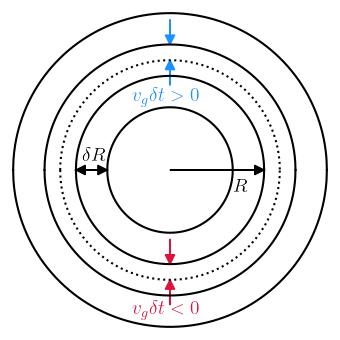

In [91]:
fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlim([-5.1, 5.1])
ax.set_ylim([-5.1, 5.1])
ax.axis("off")

def plot_circle(radius, **kwargs):
    xvals = np.linspace(-radius, radius, 1000)
    yvals = [np.sqrt(radius**2 - x**2) for x in xvals]
    ax.plot(xvals, yvals, **kwargs)
    yvals = [-np.sqrt(radius**2 - x**2) for x in xvals]
    ax.plot(xvals, yvals, **kwargs)

kwargs = {"c": named_colors()["black"]}
for _ in [2, 3, 4, 5]: plot_circle(_, **kwargs)
plot_circle(3.5, c = named_colors()["black"], linestyle = ':')
kwargs = {
    "color": named_colors()["black"],
    "length_includes_head": True,
    "head_width": 0.3,
    "head_length": 0.3
}
ax.arrow(0, 0, 3, 0, **kwargs)
ax.arrow(-2, 0, -1, 0, **kwargs)
ax.arrow(-3, 0, 1, 0, **kwargs)
kwargs["color"] = named_colors()["crimson"]
ax.arrow(0, -4.3, 0, 0.8, **kwargs)
ax.arrow(0, -2.2, 0, -0.8, **kwargs)
kwargs["color"] = named_colors()["dodgerblue"]
ax.arrow(0, 2.7, 0, 0.8, **kwargs)
ax.arrow(0, 4.8, 0, -0.8, **kwargs)
kwargs = {
    "color": named_colors()["black"],
    "fontsize": 14
}
ax.text(-2.8, 0.3, r"$\delta R$", **kwargs)
ax.text(2, -0.7, r"$R$", **kwargs)
kwargs["color"] = named_colors()["crimson"]
ax.text(-1.2, -4.6, r"$v_g \delta t < 0$", **kwargs)
kwargs["color"] = named_colors()["dodgerblue"]
ax.text(-1.2, 2.2, r"$v_g \delta t > 0$", **kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./flows/schematic.%s" % (ext), **kwargs)
plt.show()

## The definition of the flow coefficients $\gamma_\text{flow}$ and $\mu_\text{flow}$:

$$
\begin{align}
\gamma_\text{flow} &= -\tau_\star v_g
\left(\frac{1}{R} + \frac{\partial \ln \Sigma_\text{g}}{\partial R} +
\frac{\partial \ln v_g}{\partial R}\right)
\\
\mu_\text{flow} &= \gamma_\text{flow} - \tau_\star v_g
\frac{\partial \ln Z}{\partial R}.
\end{align}
$$

## Motivating values for each term:

### The SFE timescale

$$
\begin{align}
\tau_\star &\equiv \frac{\Sigma_g}{\dot{\Sigma}_\star}
\\
&\propto \frac{\Sigma_g}{\Sigma_g^\text{N}}
\\
&\propto \Sigma_g^{-1/2},
\end{align}
$$

where the final proportionality comes from adopting $N = 1.5$ from Kennicutt (1998). Based on the presence of the Milky Way disk central molecular zone, I'll adopt $\tau_{\star,0} = 2$ Gyr as the value at $R = 0$ based on Leroy et al. (2008). If the Galactic gas disk follows an exponential profile in surface density, then $\tau_\star$ would increase with radius as

$$
\tau_\star = \tau_{\star,0} e^{R / 2 R_g}
$$

where $R_g$ is the scale radius of the gas disk.

In [2]:
def tau_star(r, taustar0 = 2, Rg = 3):
    r"""
    Compute the value of the SFE timescale.

    Parameters
    ----------
    r : `float`
        Galactocentric radius in kpc.
    taustar0 : `float`
        The value in Gyr at R = 0.
    Rg : `float`
        The scale radius of the Galactic gas disk in kpc.
    """
    return taustar0 * np.exp(r / (2 * Rg))

### The velocity profile

For $v_g$, we'll consider values that are constant in radius for the sake of demonstration purposes.

### The gas density profile

If the Galactic gas disk follows an exponential profile in surface density as supposed above, then

$$
\frac{\partial \ln \Sigma_g}{\partial R} = \frac{-1}{R_g}.
$$

The Leiden-Argentine-Bonn survey (Kalberla et al. 2005) reported a value of 3.75 kpc at radii $R \gtrsim R_\odot$ (Kalberla & Kerp 2009; see discussion at the bottom of their page 2). In the interest of using round number comparisons, I'll take 4 kpc.

In [3]:
def gas_surface_density_profile(Rg = 4):
    r"""
    Compute the slope of the velocity profile :math:`d \ln \Sigma_g / d R`.

    Parameters
    ----------
    Rg : `float`
        The scale radius of the exponential disk profile in kpc.
    """
    return -1 / Rg

### The Radial Metallicity Gradient

Empirically, the radial metallicity gradient follows an exponential profile in $Z$ versus radius, which gives rise to the more commonly visualized linear relation in $\log_{10}(Z)$ versus radius. Therefore,

$$
\frac{\partial \ln Z}{\partial R} = -1 / R_Z,
$$

where $R_Z \equiv -(\nabla\text{[X/H]} \ln 10)^{-1}$ is the e-folding scale radius in the metal-disk $Z$ in terms of the measured gradient slope $\nabla \text{[X/H]}$ for some element X. Therefore

$$
\frac{\partial \ln Z}{\partial R} = \nabla\text{[X/H]} \ln 10
$$

In the interest of round number comparisons, I'll take $-0.06$ kpc$^{-1}$ based on my own measurement of $-0.062 \pm 0.001$ kpc$^{-1}$.

In [4]:
def metallicity_gradient(slope = -0.06):
    r"""
    Compute the slope of the metallicity gradient :math:`d \ln Z / d R`.

    Parameters
    ----------
    slope : `float`
        The measured slope of the abundance gradient in [X/H] in kpc^-1.
    """
    return slope * np.log(10)

# def xhdot(r, vg = -0.7, slope = -0.06):
#     vg *= _KM_PER_KPC_ * _SECONDS_PER_GYR_
#     return -vg * 0.014 / np.log(10) * metallicity_gradient(slope = slope)
def metallicity(r, slope = -0.06):
    r"""
    Compute the metallicity based on the gradient slope :math:`\nabla`[X/H]
    assuming a normalization such that :math:`Z = 0.014` at :math:`R = 8` kpc.

    Parameters
    ----------
    r : `float`
        Galactocentric radius in kpc.
    slope : `float`
        The measured slope of the abundance gradient in [X/H] in kpc^-1.
    """
    return 0.014 * np.exp((r - 8) * (slope * np.log(10)))

In [5]:
_SECONDS_PER_GYR_ = 3.1536e16
_KM_PER_KPC_ = 3.24e-17

def gamma_flow(r, vg = -0.7, taustar0 = 2, Rg = 4):
    vg *= _SECONDS_PER_GYR_
    vg *= _KM_PER_KPC_
    gamma = 1 / r + gas_surface_density_profile(Rg = Rg)
    gamma *= -tau_star(r, taustar0 = taustar0, Rg = Rg) * vg
    return gamma

def mu_flow(r, vg = -0.7, taustar0 = 2, Rg = 4, slope = -0.06):
    return gamma_flow(r, vg = vg, taustar0 = taustar0, Rg = Rg) - tau_star(
        r, taustar0 = taustar0, Rg = Rg) * vg * metallicity_gradient(slope = slope) * _SECONDS_PER_GYR_ * _KM_PER_KPC_

/var/folders/mh/jf6nfbl941l_41vvvwwk5wbr0000gn/T/ipykernel_6431/3497099428.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  gamma = 1 / r + gas_surface_density_profile(Rg = Rg)
/var/folders/mh/jf6nfbl941l_41vvvwwk5wbr0000gn/T/ipykernel_6431/23356557.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


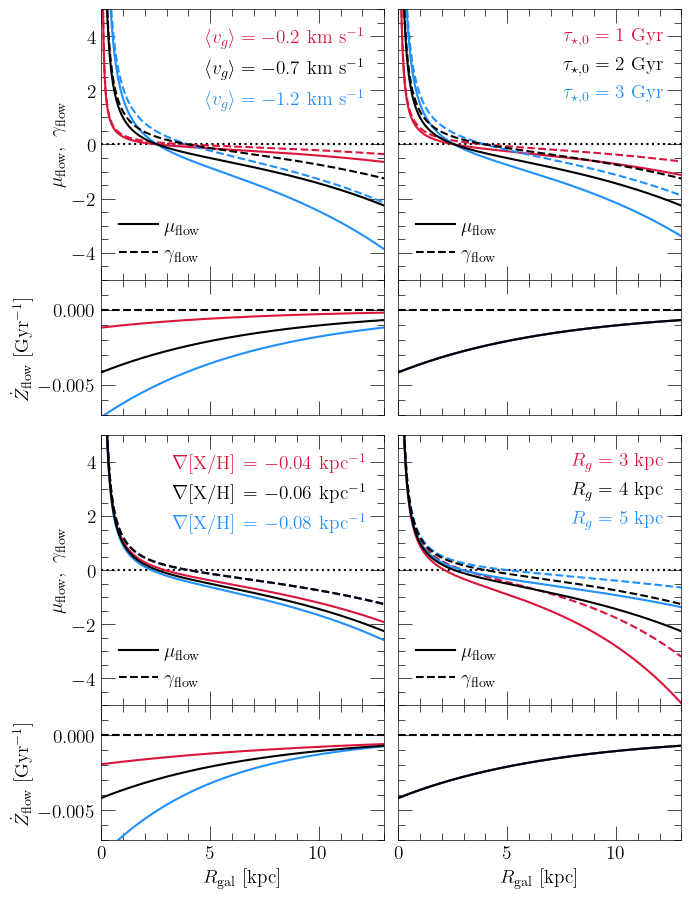

In [101]:
VG = [-0.2, -0.7, -1.2]
TAUSTAR0 = [1, 2, 3]
SLOPES = [-0.04, -0.06, -0.08]
RG = [3, 4, 5]
COLORS = ["crimson", "black", "dodgerblue"]

fig = plt.figure(figsize = (7, 9))
tops = []
bottoms = []
for i in range(4):
    kwargs = {}
    if i:
        kwargs["sharex"] = tops[0]
        kwargs["sharey"] = tops[0]
    else: pass
    tops.append(fig.add_subplot(221 + i, **kwargs))
    plt.setp(tops[i].get_xticklabels(), visible = False)
    if i % 2:
        plt.setp(tops[i].get_yticklabels(), visible = False)
    else:
        tops[i].set_ylabel(r"$\mu_\text{flow},\ \gamma_\text{flow}$")
    tops[i].set_xlim([0, 13])
    tops[i].set_xticks([0, 5, 10])
    tops[i].set_ylim([-5, 5])
    tops[i].axhline(0, c = named_colors()["black"], linestyle = ":")
for i in range(4):
    kwargs = {"sharex": tops[0]}
    if i: kwargs["sharey"] = bottoms[0]
    bottoms.append(fig.add_axes([0.1, 0.1 * (1 + i), 0.1, 0.1], **kwargs))
    if i >= 2:
        bottoms[i].set_xlabel(r"$R_\text{gal}$ [kpc]")
    else:
        plt.setp(bottoms[i].get_xticklabels(), visible = False)
    if i % 2: 
        plt.setp(bottoms[i].get_yticklabels(), visible = False)
    else:
        # bottoms[i].set_ylabel(r"$\Delta$")
        bottoms[i].set_ylabel(r"$\dot{Z}_\text{flow}$ [Gyr$^{-1}$]")
    bottoms[i].axhline(0, c = named_colors()["black"], linestyle = "--")
    bottoms[i].set_ylim([-0.007, 0.002])

for i in range(4):
    kwargs = {
        "c": named_colors()["black"],
        "linestyle": "-",
        "label": r"$\mu_\text{flow}$"
    }
    line1 = tops[i].plot([-1, -2], [-1, -2], **kwargs)[0]
    kwargs["linestyle"] = "--"
    kwargs["label"] = r"$\gamma_\text{flow}$"
    line2 = tops[i].plot([-1, -2], [-1, -2], **kwargs)[0]
    kwargs = {"loc": mpl_loc("lower left")}
    leg = tops[i].legend(**kwargs)
    line1.remove()
    line2.remove()
    tops[i].add_artist(leg)

radii = np.linspace(tops[0].get_xlim()[0], tops[0].get_xlim()[1], 500)
for i in range(len(VG)):
    kwargs = {
        "vg": VG[i],
        "taustar0": TAUSTAR0[1],
        "Rg": RG[1]
    }
    gamma = [gamma_flow(r, **kwargs) for r in radii]
    kwargs["slope"] = SLOPES[1]
    mu = [mu_flow(r, **kwargs) for r in radii]
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": "--",
        "zorder": 100 if i == 1 else None
    }
    tops[0].plot(radii, gamma, **kwargs)
    kwargs["linestyle"] = "-"
    kwargs["label"] = r"$\langle v_g \rangle = %g$ km s$^{-1}$" % (VG[i])
    tops[0].plot(radii, mu, **kwargs)
    kwargs["label"] = None
    # derivative = [xhdot(r, vg = VG[i], slope = SLOPES[1]) for r in radii]
    # bottoms[0].plot(radii, derivative, **kwargs)
    zdot = [-VG[i] * metallicity(r, slope = SLOPES[1]) * metallicity_gradient(slope = SLOPES[1]) for r in radii]
    zdot = [_ * _KM_PER_KPC_ * _SECONDS_PER_GYR_ for _ in zdot]
    bottoms[0].plot(radii, zdot, **kwargs)

for i in range(len(TAUSTAR0)):
    kwargs = {
        "vg": VG[1],
        "taustar0": TAUSTAR0[i],
        "Rg": RG[1]
    }
    gamma = [gamma_flow(r, **kwargs) for r in radii]
    kwargs["slope"] = SLOPES[1]
    mu = [mu_flow(r, **kwargs) for r in radii]
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": "--",
        "zorder": 100 if i == 1 else None
    }
    tops[1].plot(radii, gamma, **kwargs)
    kwargs["linestyle"] = "-"
    kwargs["label"] = r"$\tau_{\star,0} = %g$ Gyr" % (TAUSTAR0[i])
    tops[1].plot(radii, mu, **kwargs)
    kwargs["label"] = None
    # derivative = [xhdot(r, vg = VG[1], slope = SLOPES[1]) for r in radii]
    # bottoms[1].plot(radii, derivative, **kwargs)
    zdot = [-VG[1] * metallicity(r, slope = SLOPES[1]) * metallicity_gradient(slope = SLOPES[1]) for r in radii]
    zdot = [_ * _KM_PER_KPC_ * _SECONDS_PER_GYR_ for _ in zdot]
    bottoms[1].plot(radii, zdot, **kwargs)

for i in range(len(SLOPES)):
    kwargs = {
        "vg": VG[1],
        "taustar0": TAUSTAR0[1],
        "Rg": RG[1]
    }
    gamma = [gamma_flow(r, **kwargs) for r in radii]
    kwargs["slope"] = SLOPES[i]
    mu = [mu_flow(r, **kwargs) for r in radii]
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": "--",
        "zorder": 100 if i == 1 else None
    }
    tops[2].plot(radii, gamma, **kwargs)
    kwargs["linestyle"] = "-"
    kwargs["label"] = r"$\nabla$[X/H] = $%g$ kpc$^{-1}$" % (SLOPES[i])
    tops[2].plot(radii, mu, **kwargs)
    kwargs["label"] = None
    # derivative = [xhdot(r, vg = VG[1], slope = SLOPES[i]) for r in radii]
    # bottoms[2].plot(radii, derivative, **kwargs)
    zdot = [-VG[1] * metallicity(r, slope = SLOPES[i]) * metallicity_gradient(slope = SLOPES[i]) for r in radii]
    zdot = [_ * _KM_PER_KPC_ * _SECONDS_PER_GYR_ for _ in zdot]
    bottoms[2].plot(radii, zdot, **kwargs)

for i in range(len(RG)):
    kwargs = {
        "vg": VG[1],
        "taustar0": TAUSTAR0[1],
        "Rg": RG[i],
    }
    gamma = [gamma_flow(r, **kwargs) for r in radii]
    kwargs["slope"] = SLOPES[1]
    mu = [mu_flow(r, **kwargs) for r in radii]
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": "--",
        "zorder": 100 if i == 1 else None
    }
    tops[3].plot(radii, gamma, **kwargs)
    kwargs["linestyle"] = "-"
    kwargs["label"] = r"$R_g = %g$ kpc" % (RG[i])
    tops[3].plot(radii, mu, **kwargs)
    kwargs["label"] = None
    # derivative = [xhdot(r, vg = VG[1], slope = SLOPES[1]) for r in radii]
    # bottoms[3].plot(radii, derivative, **kwargs)
    zdot = [-VG[1] * metallicity(r, slope = SLOPES[1]) * metallicity_gradient(slope = SLOPES[1]) for r in radii]
    zdot = [_ * _KM_PER_KPC_ * _SECONDS_PER_GYR_ for _ in zdot]
    bottoms[3].plot(radii, zdot, **kwargs)

# bottoms[0].text(8, -0.005, r"$\propto -e^{-R}$", fontsize = 14)

kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0,
    "ncol": 1
}
for i in range(4):
    leg = tops[i].legend(**kwargs)
    fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0.05, wspace = 0.05, bottom = 0.06, left = 0.15)
bottom_panel_height = 0.15
for i in range(4):
    tops[i].set_position([
        tops[i].get_position().x0,
        tops[i].get_position().y0 + bottom_panel_height,
        tops[i].get_position().x1 - tops[i].get_position().x0,
        tops[i].get_position().y1 - tops[i].get_position().y0 - bottom_panel_height
    ])
    bottoms[i].set_position([
        tops[i].get_position().x0,
        tops[i].get_position().y0 - bottom_panel_height,
        tops[i].get_position().x1 - tops[i].get_position().x0,
        bottom_panel_height
    ])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./flows/muflow-gammaflow-vs-radius.%s" % (ext), **kwargs)
plt.show()

$$
\begin{align}
\dot{Z}_\text{flow} &= \frac{M_g \dot{M}_{x,\text{flow}} - M_x \dot{M}_{g,\text{flow}}}{M_g^2}
\\
&= \frac{\dot{M}_\star \tau_\star \mu_\text{flow} Z \dot{M}_\star}{\dot{M}_\star^2 \tau_\star^2} -
Z \frac{\gamma_\text{flow} \dot{M}_\star}{\dot{M}_\star \tau_\star}
\\
&= \frac{Z}{\tau_\star}\left(\mu_\text{flow} - \gamma_\text{flow}\right)
\\
&= \frac{Z}{\tau_\star}\left(-\tau_\star v_g \frac{\partial \ln Z}{\partial R}\right)
\\
&= -v_g \frac{\partial Z}{\partial R}
\\
\implies \frac{\partial{\text{[X/H]}}_\text{flow}}{\partial t} &= \frac{\partial}{\partial t}
\log_{10}\left(\frac{Z}{Z_\odot}\right)
\\
&= \frac{Z_\odot}{Z \ln 10} \dot{Z}_\text{flow}
\\
&= -v_g \frac{Z_\odot}{\ln 10} \frac{\partial \ln Z}{\partial R}
\\
&= -v_g Z_\odot \nabla\text{[X/H]}
\end{align}
$$

In [8]:
name = "../outputs/test"
output = vice.output(name)
extra = np.genfromtxt("%s_analogdata.out" % (output.name))
output.stars["absz"] = [abs(_) for _ in extra[:, -1][:output.stars.size[0]]]

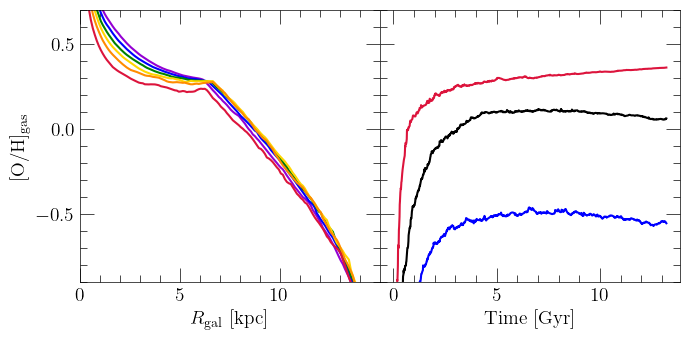

In [9]:
ELEMENT = "O"
RADII = [4, 8, 12]
RADII_COLORS = ["crimson", "black", "blue"]
AGES = [0, 2, 4, 6, 8, 10]
AGE_COLORS = ["darkviolet", "blue", "green", "gold", "darkorange", "crimson"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (7, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey = ax1)
ax1.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax2.set_xlabel(r"Time [Gyr]")
ax1.set_ylabel(r"[%s/H]$_\text{gas}$" % (ELEMENT.capitalize()))
plt.setp(ax2.get_yticklabels(), visible = False)
ax1.set_ylim([-0.9, 0.7])
ax1.set_yticks([-0.5, 0, 0.5])
ax1.set_xlim([0, 15])
ax1.set_xticks([0, 5, 10])

for i in range(len(AGES)):
    diff = [abs(_ - AGES[i]) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = [ZONE_WIDTH * (i + 0.5) for i in range(155)]
    xh = []
    for j in range(len(radii)): xh.append(
        output.zones["zone%d" % (j)].history["[%s/h]" % (ELEMENT)][idx])
    kwargs = {"c": named_colors()[AGE_COLORS[i]]}
    if AGES[i]:
        kwargs["label"] = "%d Gyr ago" % (AGES[i])
    else:
        kwargs["label"] = "Present Day"
    ax1.plot(radii, xh, **kwargs)

for i in range(len(RADII)):
    zone = int(RADII[i] / ZONE_WIDTH)
    zone = output.zones["zone%d" % (zone)]
    kwargs = {
        "c": named_colors()[RADII_COLORS[i]],
        "label": "%d kpc" % (RADII[i])
    }
    ax2.plot(zone.history["time"], zone.history["[%s/h]" % (ELEMENT)], **kwargs)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
plt.show()

In [23]:
names = [
    "../outputs/inside-out/eta-0/vrad2",
    "../old-outputs/inside-out/vrad0"
    # "../outputs/inside-out/eta-0/vrad1",
    # "../outputs/inside-out/eta-0/vrad2",
    # "../outputs/inside-out/eta-0/vrad3"
]
outputs = [vice.output(name) for name in names]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:, -1][:out.stars.size[0]]]

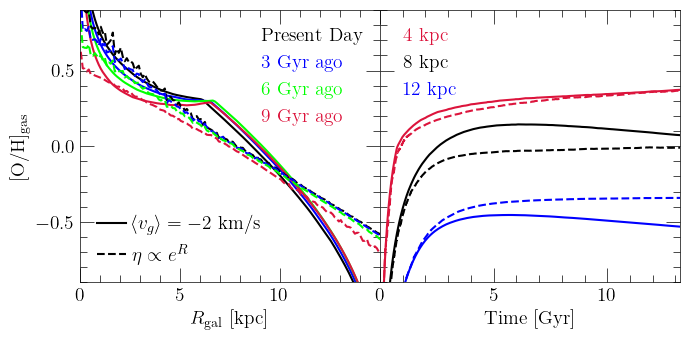

In [31]:
ELEMENT = "O"
AGES = [0, 3, 6, 9]
# LINESTYLES = ["-", "--", "-.", ":"]
AGES_COLORS = ["black", "blue", "lime", "crimson"]
RADII = [4, 8, 12]
RADII_COLORS = ["crimson", "black", "blue"]
LINESTYLES = ["-", "--"]
MODEL_LABELS = [r"$\langle v_g \rangle = -2$ km/s", r"$\eta \propto e^R$"]
# VGAS = [-1, -2, -3]
# COLORS = ["black", "crimson", "blue"]
# LINESTYLES = ["-", "--", "-."]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (7, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey = ax1)
ax1.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax2.set_xlabel(r"Time [Gyr]")
ax1.set_ylabel(r"[%s/H]$_\text{gas}$" % (ELEMENT.capitalize()))
plt.setp(ax2.get_yticklabels(), visible = False)
ax1.set_ylim([-0.9, 0.9])
ax1.set_yticks([-0.5, 0, 0.5])
ax1.set_xlim([0, 15])
ax1.set_xticks([0, 5, 10])
ax2.set_xlim([0, 13.2])
ax2.set_xticks([0, 5, 10])

lines = []
for i in range(len(LINESTYLES)):
    kwargs = {
        "c": named_colors()["black"],
        "linestyle": LINESTYLES[i],
        "label": MODEL_LABELS[i]
    }
    lines.append(ax1.plot([-1, -2], [-1, -2], **kwargs)[0])
kwargs = {
    "loc": mpl_loc("lower left"),
    "ncol": 1,
    "handlelength": 1.5
}
leg = ax1.legend(**kwargs)
ax1.add_artist(leg)
for line in lines: line.remove()

for i, out in enumerate(outputs):
    for j in range(len(AGES)):
        diff = [abs(_ - AGES[j]) for _ in out.zones["zone0"].history["lookback"]]
        idx = diff.index(min(diff))
        radii = [ZONE_WIDTH * (i + 0.5) for i in range(155)]
        xh = []
        for k in range(len(radii)): xh.append(
            out.zones["zone%d" % (k)].history["[%s/h]" % (ELEMENT)][idx])
        kwargs = {
            "c": named_colors()[AGES_COLORS[j]],
            "linestyle": LINESTYLES[i]
        }
        if not i:
            if AGES[j]:
                kwargs["label"] = "%d Gyr ago" % (AGES[j])
            else:
                kwargs["label"] = "Present Day"
        else: pass
        ax1.plot(radii, xh, **kwargs)
    for j in range(len(RADII)):
        zone = int(RADII[j] / ZONE_WIDTH)
        zone = out.zones["zone%d" % (zone)]
        kwargs = {
            "c": named_colors()[RADII_COLORS[j]],
            "linestyle": LINESTYLES[i]
        }
        if not i: kwargs["label"] = "%d kpc" % (RADII[j])
        ax2.plot(zone.history["time"], zone.history["[%s/h]" % (ELEMENT)], **kwargs)

kwargs = {
    "loc": mpl_loc("upper right"),
    "ncol": 1,
    "handlelength": 0
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, AGES_COLORS)

kwargs["loc"] = mpl_loc("upper left")
leg = ax2.legend(**kwargs)
fancy_legend(leg, RADII_COLORS)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./flows/grad-%sh-outflows-vs-radialflows-demo.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()

In [39]:
names = [
    "../outputs/inside-out/eta-eR/vrad0",
    "../outputs/inside-out/eta-eR/vrad1",
    "../outputs/inside-out/eta-eR/vrad2",
    "../outputs/inside-out/eta-eR/vrad3"
]
outputs = [vice.output(name) for name in names]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:, -1][:out.stars.size[0]]]

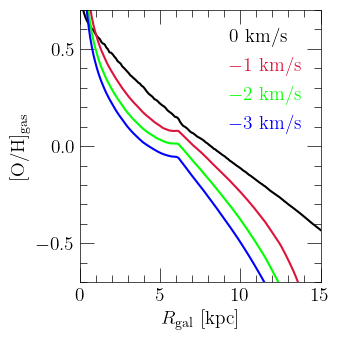

In [46]:
ELEMENT = "O"
VGAS = [0, -1, -2, -3]
COLORS = ["black", "crimson", "lime", "blue"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"[%s/H]$_\text{gas}$" % (ELEMENT.capitalize()))
ax.set_xlim([0, 15])
ax.set_ylim([-0.7, 0.7])
ax.set_yticks([-0.5, 0, 0.5])

for i, out in enumerate(outputs):
    radii = [ZONE_WIDTH * (i + 0.5) for i in range(155)]
    xh = []
    for j in range(len(radii)): xh.append(
        out.zones["zone%d" % (j)].history["[%s/h]" % (ELEMENT)][-1])
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"$%g$ km/s" % (VGAS[i])
    }
    ax.plot(radii, xh, **kwargs)

kwargs = {
    "loc": mpl_loc("upper right"),
    "ncol": 1,
    "handlelength": 0
}
leg = ax.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
for ext in ["jpeg", "pdf"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./flows/gas-grad-%sh-velocity-comp.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()

In [64]:
names = [
    "../outputs/outerburst/eta-eR/vrad0",
    "../outputs/outerburst/eta-eR/vrad2",
    "../outputs/outerburst/eta-0/vrad2"
]
outputs = [vice.output(name) for name in names]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:, -1][:out.stars.size[0]]]

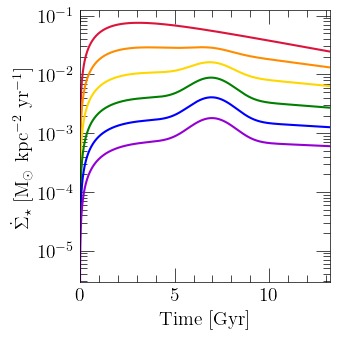

In [68]:
RADII = [3, 5, 7, 9, 11, 13]
COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Time [Gyr]")
ax.set_ylabel(r"$\dot{\Sigma}_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax.set_xlim([0, 13.2])
ax.set_yscale("log")

def plot_sfh(out):
    for i in range(len(RADII)):
        zone = int(RADII[i] / ZONE_WIDTH)
        zone = out.zones["zone%d" % (zone)]
        area = np.pi * ((RADII[i] + ZONE_WIDTH)**2 - RADII[i]**2)
        sfh = [_ / area for _ in zone.history["sfr"]]
        kwargs = {
            "c": named_colors()[COLORS[i]],
            "label": "%d kpc" % (RADII[i])
        }
        ax.plot(zone.history["time"], sfh, **kwargs)

plot_sfh(outputs[0])

plt.tight_layout()
plt.show()

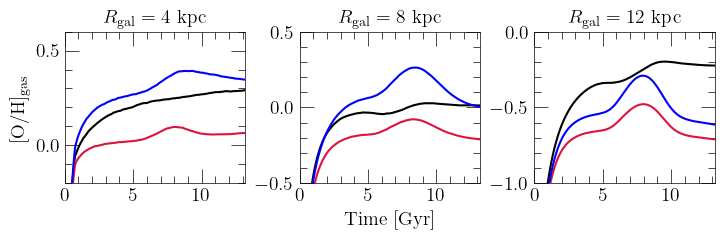

In [77]:
ELEMENT = "O"
RADII = [4, 8, 12]
# COLORS = ["crimson", "black", "blue"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (7.5, 2.5))
axes = []
for i in range(len(RADII)):
    kwargs = {}
    if i:
        # kwargs["sharey"] = axes[0]
        kwargs["sharex"] = axes[0]
    else: pass
    axes.append(fig.add_subplot(131 + i, **kwargs))
    axes[i].set_title(r"$R_\text{gal} = %d$ kpc" % (RADII[i]))
    # if i: plt.setp(axes[i].get_yticklabels(), visible = False)
# axes[0].set_ylim([-1.6, 0.6])
# axes[0].set_yticks([-0.5, 0, 0.5])
axes[1].set_xlabel(r"Time [Gyr]")
axes[0].set_ylabel(r"[%s/H]$_\text{gas}$" % (ELEMENT.capitalize()))
axes[0].set_xlim([0, 13.2])
axes[0].set_xticks([0, 5, 10])
axes[0].set_ylim([-0.2, 0.6])
axes[1].set_ylim([-0.5, 0.5])
axes[2].set_ylim([-1, 0])

def plot_predictions(out, **plot_kwargs):
    for i in range(len(RADII)):
        zone = int(RADII[i] / ZONE_WIDTH)
        zone = out.zones["zone%d" % (zone)]
        axes[i].plot(zone.history["time"], zone.history["[%s/h]" % (ELEMENT)], **plot_kwargs)

plot_predictions(outputs[0], c = named_colors()["black"],
    label = r"$\eta \propto e^R$; $\langle v_g \rangle = 0$")
plot_predictions(outputs[1], c = named_colors()["crimson"],
    label = r"$\eta \propto e^R$; $\langle v_g \rangle = -2$ km/s")
plot_predictions(outputs[2], c = named_colors()["blue"],
    label = r"$\eta = 0$; $\langle v_g \rangle = -2$ km/s")

plt.tight_layout()
plt.subplots_adjust(wspace = 0.3)
plt.show()